In [1]:
import sys
import numpy as np
sys.path.append("../")
from data_loading import load_runs

In [2]:
RUN = ["3_crt"]
rundata, mc_weights, data_pot = load_runs(
    RUN,
    data="bnb",  # which data to load
    # truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
    # Which truth-filtered MC sets to load in addition to the main MC set. At least nu_e and dirt
    # are highly recommended because the statistics at the final level of the selection are very low.
    truth_filtered_sets=["nue", "drt"],
    # Choose which additional variables to load. Which ones are required may depend on the selection
    # you wish to apply.
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_crt_vars=True,
    # Load the nu_e set one more time with the LEE weights applied
    load_lee=False,
    # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
    # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
    enable_cache=True,
    # Since this is Open Data, we are allowed to unblind the data. By default, the data is blinded.
    blinded=False,
)

Loading run 3_crt


['drt', 'ext', 'nue', 'mc']


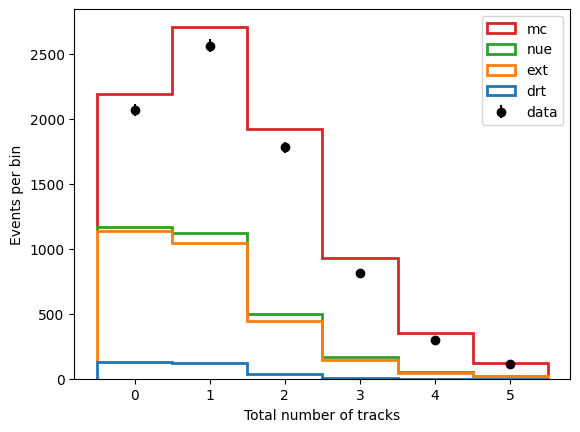

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of reconstructed neutrino energy (`reco_e`).
# We have to set the binning manually because sometimes a filler value is used
# that is a very large number. To get the total predicted number of events,
# we have to add all MC sets and the EXT data set.

bins = np.linspace(-0.5, 5.5, 7)
variable = "n_tracks_tot"
variable_label = "Total number of tracks"
background_keys = list(set(rundata.keys()) - set(["data", "lee"]))
print(background_keys)
plt.hist(
    [rundata[key][variable] for key in background_keys],
    bins=bins,
    weights=[rundata[key]["weights"] for key in background_keys],
    histtype="step",
    lw=2,
    stacked=True,
    label=[key for key in background_keys],
)
# show data hist on top as points with error bars
data_bin_content, data_bin_edges = np.histogram(
    rundata["data"][variable], bins=bins, weights=rundata["data"]["weights"]
)
data_bin_errors = np.sqrt(data_bin_content)
data_bin_centers = (data_bin_edges[:-1] + data_bin_edges[1:]) / 2
plt.errorbar(
    data_bin_centers,
    data_bin_content,
    yerr=data_bin_errors,
    fmt="o",
    label="data",
    color="black",
)
plt.legend()
plt.xlabel(variable_label)
plt.ylabel("Events per bin")
plt.show()

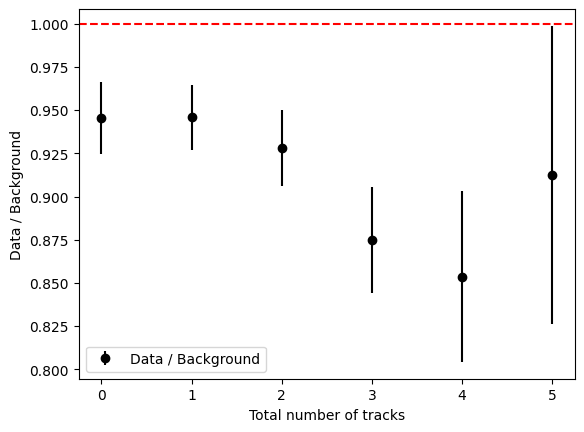

In [4]:
# Calculate the total background prediction
background_prediction = sum(
    np.histogram(rundata[key][variable], bins=bins, weights=rundata[key]["weights"])[0]
    for key in background_keys
)

# Calculate the ratio
with np.errstate(divide="ignore", invalid="ignore"):
    ratio = data_bin_content / background_prediction
    ratio_errors = data_bin_errors / background_prediction

# Plot the ratio
plt.errorbar(
    data_bin_centers,
    ratio,
    yerr=ratio_errors,
    fmt="o",
    label="Data / Background",
    color="black",
)
plt.axhline(1, color='r', linestyle='--')
plt.xlabel(variable_label)
plt.ylabel("Data / Background")
plt.legend()
plt.show()

In [5]:
def make_histograms(variable, run, bins):
    """Make histograms of data and background for a given variable."""
    # Function should not make plots, but return the histogram bin counts
    # and errors, as well as the data POT.

    rundata, mc_weights, data_pot = load_runs(
        run,
        data="bnb",  # which data to load
        # truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
        # Which truth-filtered MC sets to load in addition to the main MC set. At least nu_e and dirt
        # are highly recommended because the statistics at the final level of the selection are very low.
        truth_filtered_sets=["nue", "drt"],
        # Choose which additional variables to load. Which ones are required may depend on the selection
        # you wish to apply.
        loadpi0variables=True,
        loadshowervariables=True,
        loadrecoveryvars=True,
        loadsystematics=True,
        load_crt_vars=True,
        # Load the nu_e set one more time with the LEE weights applied
        load_lee=False,
        # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
        # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
        enable_cache=True,
        # Since this is Open Data, we are allowed to unblind the data. By default, the data is blinded.
        blinded=False,
    )

    # Make total background histogram
    background_keys = list(set(rundata.keys()) - set(["data", "lee"]))
    background_prediction = sum(
        np.histogram(rundata[key][variable], bins=bins, weights=rundata[key]["weights"])[0]
        for key in background_keys
    )
    # Background errors using squared weights
    background_prediction_errors = np.sqrt(
        sum(
            np.histogram(rundata[key][variable], bins=bins, weights=rundata[key]["weights"] ** 2)[0]
            for key in background_keys
        )
    )

    # Make data histogram
    data_bin_content, data_bin_edges = np.histogram(
        rundata["data"][variable], bins=bins, weights=rundata["data"]["weights"]
    )
    data_bin_errors = np.sqrt(data_bin_content)

    # Calculate the ratio, propagate errors
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = data_bin_content / background_prediction
        ratio_errors = ratio * np.sqrt(
            (data_bin_errors / data_bin_content) ** 2
            + (background_prediction_errors / background_prediction) ** 2
        )

    return dict(
        data_bin_content=data_bin_content,
        data_bin_errors=data_bin_errors,
        background_prediction=background_prediction,
        background_prediction_errors=background_prediction_errors,
        ratio=ratio,
        ratio_errors=ratio_errors,
        data_pot=data_pot,
    )


In [21]:
def plot_run_ratios(variable, variable_label, bins, save_location=None):
    """Plot the data/background ratio for all runs."""
    all_runs = ["1", "2", "3", "4b", "4c", "4d", "5"]

    all_run_data = {}
    for run in all_runs:
        all_run_data[run] = make_histograms(variable, [run], bins)

    plt.figure()
    for run, data in all_run_data.items():
        plt.errorbar(
            (bins[:-1] + bins[1:]) / 2,
            data["ratio"],
            yerr=data["ratio_errors"],
            xerr=(bins[1] - bins[0]) / 2,
            fmt="o",
            label=f"Run {run}, {data['data_pot']:.1e} POT",
        )

    plt.axhline(1, color="black", linestyle="--")
    plt.xlabel(variable_label)
    plt.ylabel("Data / (MC + EXT)")
    plt.legend(ncol=2)
    plt.ylim((0.5, 1.5))
    plt.grid()
    if save_location is not None:
        plt.savefig(save_location, bbox_inches="tight")

Loading run 1
Loading run 2
Loading run 3
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading run 1
Loading run 2
Loading run 3
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading run 1
Loading run 2
Loading run 3
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading run 1
Loading run 2
Loading run 3
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5


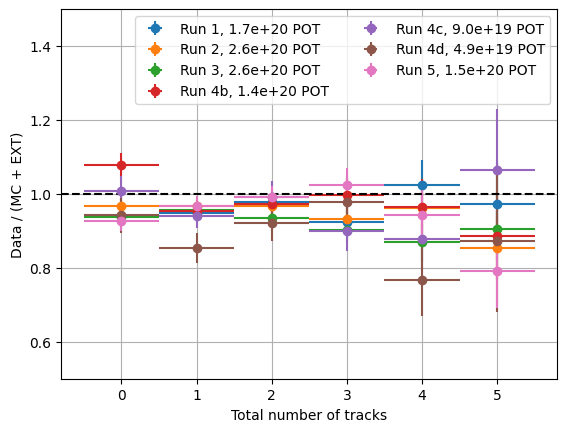

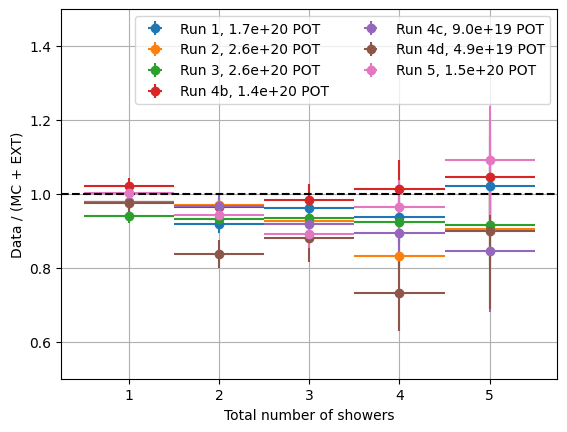

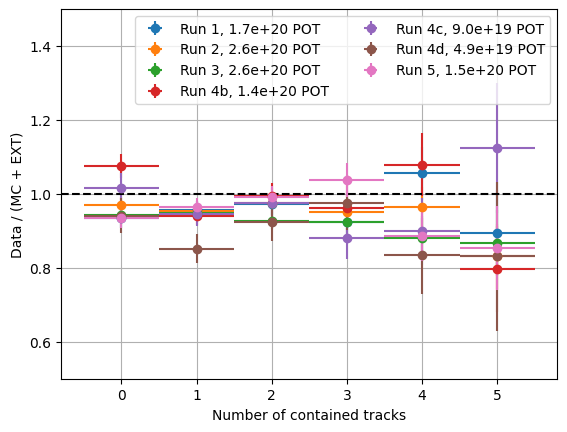

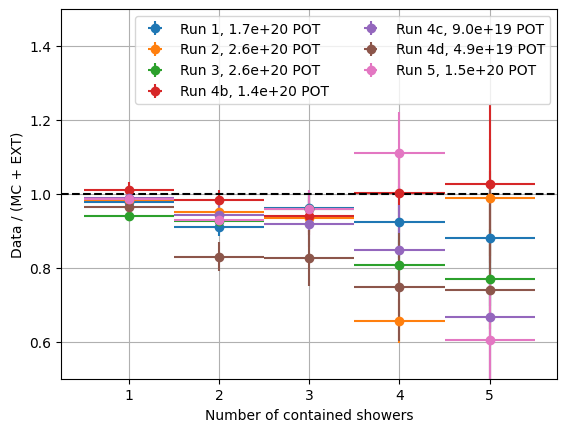

In [22]:
import os

for variable, variable_label in zip(
    ["n_tracks_tot", "n_showers_tot", "n_tracks_contained", "n_showers_contained"],
    ["Total number of tracks", "Total number of showers", "Number of contained tracks", "Number of contained showers"],
):
    bins = np.linspace(-0.5, 5.5, 7)
    save_location = os.path.join("seminar_plots", f"{variable}_ratio.pdf")

    plot_run_ratios(variable, variable_label, bins, save_location)